In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sklearn as sk
from tqdm import tqdm

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

(5060, 715)
(5060, 136)
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22']
['01']


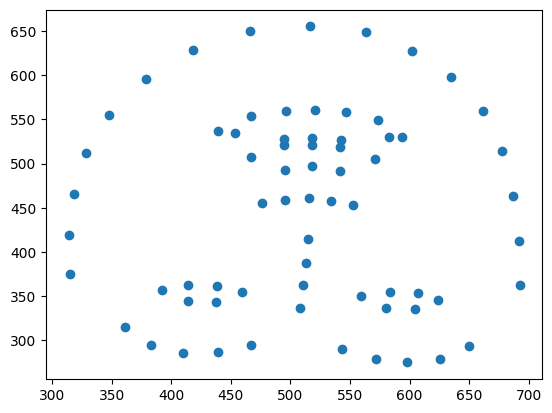

In [2]:
df = pd.read_csv("Database.csv")
print(df.shape)
#au = df.iloc[:, 679:696]
df = df.iloc[:, 299:435]
plt.scatter(df.iloc[0, 0:68], df.iloc[0, 68:136])
dfn = sk.preprocessing.normalize(df)
df=pd.DataFrame(dfn)
#df = (df-df.mean())/df.std()
#df = df + au
print(df.shape)
# Read class labels
f = open("labelsDefault.txt", "r")
labels=f.read().splitlines()
labels.pop(0)

# Add y column, which is the target variable
df['y'] = labels
print(df["y"].unique())
# Get dataset only for class 1
dft = df.loc[df['y'] == "01"]
#dft=pd.concat([df.loc[df['y'] == "01"], df.loc[df['y'] == "02"]])
print(dft["y"].unique())

In [3]:
target = torch.tensor(dft['y'].values.astype(np.int_))
data = torch.tensor(dft.drop('y', axis = 1).values.astype(np.float32)) 
df_tensor = torch.utils.data.TensorDataset(data, target)

In [4]:
#Load data into a PyTorch dataset
train_loader = DataLoader(dataset=df_tensor, batch_size=32, shuffle=True)
train_features, train_labels = next(iter(train_loader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 136])
Labels batch shape: torch.Size([32])


In [5]:
# Creating a PyTorch class
# 18 ==> 3 ==> 18

class AE(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(136, 40),
			torch.nn.Sigmoid(),
			torch.nn.Linear(40, 20),
    		torch.nn.Sigmoid()
		)
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(20, 40),
			torch.nn.Sigmoid(),
			torch.nn.Linear(40, 136),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return decoded


In [6]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)


In [7]:
epochs = 100
losses = []
writer = SummaryWriter()

for epoch in range(epochs):
    for data in train_loader:
        features, _ = data
        optimizer.zero_grad()
        reconstructed = model(features)
        loss = loss_function(reconstructed, features)
        loss.backward()
        reconstruction_error = torch.mean((reconstructed - features)**2)
        optimizer.step()
        losses.append(loss.item())

    print(f'Epoch: {epoch}, Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Reconstruction error: {reconstruction_error.item()}')
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Error', reconstruction_error.item(), epoch)



Epoch: 0, Loss: 0.007313139270991087
Epoch: 0, Reconstruction error: 0.007313139270991087
Epoch: 1, Loss: 0.007350669242441654
Epoch: 1, Reconstruction error: 0.007350669242441654
Epoch: 2, Loss: 0.00735224224627018
Epoch: 2, Reconstruction error: 0.00735224224627018
Epoch: 3, Loss: 0.007352531421929598
Epoch: 3, Reconstruction error: 0.007352531421929598
Epoch: 4, Loss: 0.007352618966251612
Epoch: 4, Reconstruction error: 0.007352618966251612
Epoch: 5, Loss: 0.007352651562541723
Epoch: 5, Reconstruction error: 0.007352651562541723
Epoch: 6, Loss: 0.007352661807090044
Epoch: 6, Reconstruction error: 0.007352661807090044
Epoch: 7, Loss: 0.0073526641353964806
Epoch: 7, Reconstruction error: 0.0073526641353964806
Epoch: 8, Loss: 0.007352663204073906
Epoch: 8, Reconstruction error: 0.007352663204073906
Epoch: 9, Loss: 0.007352658547461033
Epoch: 9, Reconstruction error: 0.007352658547461033
Epoch: 10, Loss: 0.00735265389084816
Epoch: 10, Reconstruction error: 0.00735265389084816
Epoch: 11,

In [8]:
#Load tensorboard
#tensorboard --logdir=runs
#http://localhost:6006/

#torch.save(model.state_dict(), 'It_just_works')

torch.Size([6, 136])


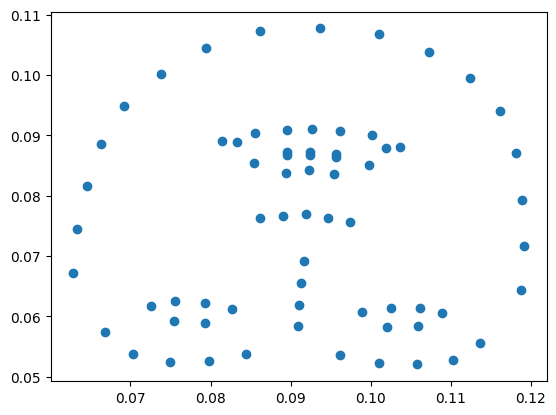

In [9]:
print(data[0].shape)
plt.scatter(data[0][1, 0:68], data[0][1, 68:137])

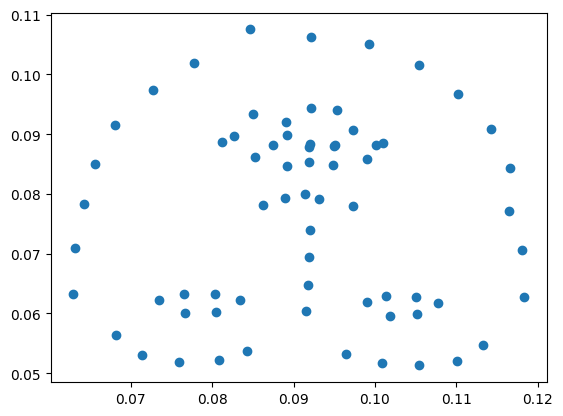

In [10]:
after = model.forward(torch.Tensor(data[0][1, 0:137]))
after = after.detach()
plt.scatter(after[0:68], after[68:137])

In [11]:
models = []

for i in df["y"].unique():
    print(i)
    dft = df.loc[df['y'] == i]
    print(dft["y"].unique())
    target = torch.tensor(dft['y'].values.astype(np.int_))
    data = torch.tensor(dft.drop('y', axis = 1).values.astype(np.float32)) 
    df_tensor = torch.utils.data.TensorDataset(data, target)

    #Load data into a PyTorch dataset
    train_loader = DataLoader(dataset=df_tensor, batch_size=32, shuffle=True)
    train_features, train_labels = next(iter(train_loader))

    #print(f"Feature batch shape: {train_features.size()}")
    #print(f"Labels batch shape: {train_labels.size()}")

    epochs = 100
    losses = []
    writer = SummaryWriter()
    
    # Model Initialization
    model = AE()

    for epoch in range(epochs):
        for data in train_loader:
            features, _ = data
            optimizer.zero_grad()
            reconstructed = model(features)
            loss = loss_function(reconstructed, features)
            loss.backward()
            reconstruction_error = torch.mean((reconstructed - features)**2)
            optimizer.step()
            losses.append(loss.item())

        #print(f'Epoch: {epoch}, Loss: {loss.item()}')
        #print(f'Epoch: {epoch}, Reconstruction error: {reconstruction_error.item()}')
        writer.add_scalar('Loss', loss.item(), epoch)
        writer.add_scalar('Error', reconstruction_error.item(), epoch)
    model.training=False
    models.append(model)
    print(losses)


01
['01']
[0.18494969606399536, 0.18483945727348328, 0.18493321537971497, 0.18491314351558685, 0.18485625088214874, 0.18496274948120117, 0.18492339551448822, 0.1847979575395584, 0.18492068350315094, 0.18478624522686005, 0.18484807014465332, 0.18490983545780182, 0.18498766422271729, 0.18486110866069794, 0.1850370317697525, 0.1849430650472641, 0.18482179939746857, 0.18490423262119293, 0.18486598134040833, 0.18495778739452362, 0.18498852849006653, 0.18484686315059662, 0.18494953215122223, 0.18502821028232574, 0.18481355905532837, 0.18500816822052002, 0.1848221719264984, 0.18484143912792206, 0.18497003614902496, 0.18493834137916565, 0.1849520057439804, 0.18496961891651154, 0.18487314879894257, 0.18497176468372345, 0.18494366109371185, 0.18487487733364105, 0.1849595308303833, 0.18488067388534546, 0.18481917679309845, 0.18509158492088318, 0.18484917283058167, 0.1848868429660797, 0.18495197594165802, 0.18479546904563904, 0.1849403828382492, 0.1849673092365265, 0.18500250577926636, 0.184713646

In [12]:
correct = 0
total = 5060
res = []
for index, row in tqdm(df.iterrows()):
    min_loss = 1000000000
    test = torch.Tensor(row[:136])
    result = 23
    for i, model in enumerate(models):
        after = model(test)
        after = after.detach()
        loss = loss_function(after, test)
        if loss < min_loss:
            result = i+1
            min_loss = loss
    res.append(result)
    if int(row.iloc[136]) == result:
        correct += 1
print(correct, total)
print(correct/total)
print(np.unique(np.array(res), return_counts=True))

0it [00:00, ?it/s]

5060it [00:28, 180.66it/s]

230 5060
0.045454545454545456
(array([6]), array([5060], dtype=int64))


In [13]:
avgs_loss = []
for model in tqdm(models):
    s = 0
    for index, row in df.iterrows():
        test = torch.Tensor(row[:136])
        after = model(test)
        after = after.detach()
        s += loss_function(after, test)
    avgs_loss.append(s/(index+1))
print(avgs_loss)


100%|██████████| 22/22 [00:57<00:00,  2.63s/it]

[tensor(0.1849), tensor(0.1698), tensor(0.1829), tensor(0.1825), tensor(0.1838), tensor(0.1693), tensor(0.1733), tensor(0.1787), tensor(0.1814), tensor(0.1813), tensor(0.1817), tensor(0.1775), tensor(0.1854), tensor(0.1767), tensor(0.1883), tensor(0.1800), tensor(0.1793), tensor(0.1699), tensor(0.1762), tensor(0.1794), tensor(0.1722), tensor(0.1782)]


In [14]:
correct = 0
total = 5060
res = []
for index, row in tqdm(df.iterrows()):
    min_loss = 1000000
    test = torch.Tensor(row[:136])
    result = 23
    for i, model in enumerate(models):
        after = model(test)
        after = after.detach()
        loss = loss_function(after, test)
        if np.abs(loss-avgs_loss[i])/avgs_loss[i] < min_loss:
            result = i+1
            min_loss = np.abs(loss-avgs_loss[i])/avgs_loss[i]
    res.append(result)
    if int(row.iloc[136]) == result:
        correct += 1
print(correct, total)
print(correct/total)
print(np.unique(np.array(res), return_counts=True))

5060it [00:52, 96.97it/s] 

265 5060
0.05237154150197629
(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22]), array([ 102,   43,  133,   37,  291,   54,   77,   42,  162,   39,  348,
         34,  464, 1498,  116,  180,   49, 1062,   55,   29,  119,  126],
      dtype=int64))
